In [39]:
# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

In [40]:
###############################################################################
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
np.random.seed(42)

# for machine learning we use the data directly (as relative pixel position info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

In [41]:
X.shape

(1288, 1850)

In [42]:
n_features

1850

In [43]:
target_names

array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Hugo Chavez', 'Tony Blair'], dtype='<U17')

In [44]:
# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print ("Total dataset size:")
print ("n_samples: %d" % n_samples)
print ("n_features: %d" % n_features)
print ("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [51]:
###############################################################################
# Split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

###############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

print ("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]))
t0 = time()
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
# pca = RandomizedPCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)      # sugggestion stackoverflow

print ("done in %0.3fs" % (time() - t0))

Extracting the top 150 eigenfaces from 966 faces
done in 0.062s


In [52]:
eigenfaces = pca.components_.reshape((n_components, h, w))

print ("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print ("done in %0.3fs" % (time() - t0))

Projecting the input data on the eigenfaces orthonormal basis
done in 0.011s


In [53]:
###############################################################################
# Train a SVM classification model

print ("Fitting the classifier to the training set")
t0 = time()
param_grid = {
         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }
# for sklearn version 0.16 or prior, the class_weight parameter value is 'auto'
clf = GridSearchCV   (SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print ("done in %0.3fs" % (time() - t0))
print ("Best estimator found by grid search:")
print (clf.best_estimator_)

Fitting the classifier to the training set
done in 28.662s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.005)


In [54]:
###############################################################################
# Quantitative evaluation of the model quality on the test set

print ("Predicting the people names on the testing set:\n")
t0 = time()
y_pred = clf.predict(X_test_pca)
print ("done in %0.3fs" % (time() - t0))

print (classification_report(y_test, y_pred, target_names=target_names),'\n\n\n')
print (confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting the people names on the testing set:

done in 0.046s
                   precision    recall  f1-score   support

     Ariel Sharon       0.75      0.46      0.57        13
     Colin Powell       0.78      0.87      0.82        60
  Donald Rumsfeld       0.89      0.63      0.74        27
    George W Bush       0.83      0.98      0.90       146
Gerhard Schroeder       0.95      0.80      0.87        25
      Hugo Chavez       1.00      0.47      0.64        15
       Tony Blair       1.00      0.75      0.86        36

         accuracy                           0.84       322
        macro avg       0.89      0.71      0.77       322
     weighted avg       0.86      0.84      0.84       322
 



[[  6   2   0   5   0   0   0]
 [  1  52   1   6   0   0   0]
 [  0   3  17   7   0   0   0]
 [  0   3   0 143   0   0   0]
 [  0   1   0   4  20   0   0]
 [  0   4   0   3   1   7   0]
 [  1   2   1   5   0   0  27]]


In [55]:

###############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)


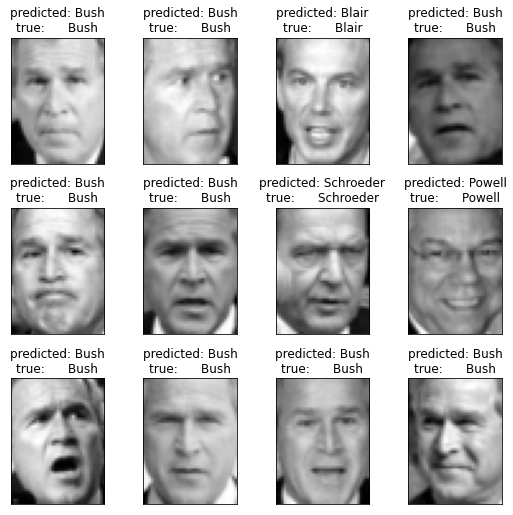

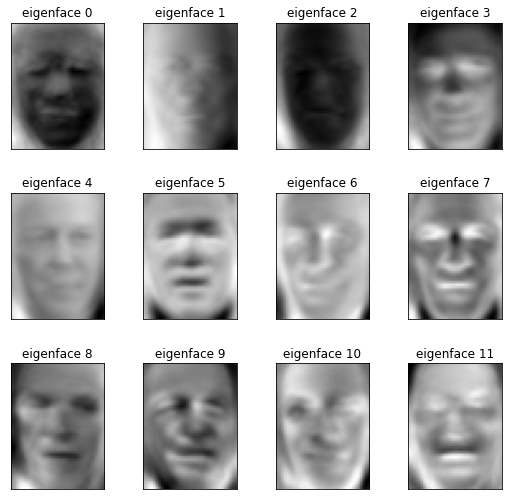

In [56]:
prediction_titles = [title(y_pred, y_test, target_names, i)
                         for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

pl.show()


In [57]:
pca.components_[0]

array([-0.00685208, -0.00752703, -0.00918911, ..., -0.01433779,
       -0.01294183, -0.01188285], dtype=float32)

In [58]:
pca.components_[1]

array([ 0.02304092,  0.02155211,  0.02275388, ..., -0.0440019 ,
       -0.04318584, -0.04226128], dtype=float32)

In [59]:
pca.explained_variance_

array([501418.4    , 391794.3    , 183592.78   , 154257.12   ,
       133670.8    ,  74828.57   ,  65169.72   ,  56409.15   ,
        52337.86   ,  49298.8    ,  43599.164  ,  40965.547  ,
        31706.814  ,  28196.893  ,  27588.2    ,  25390.406  ,
        23128.975  ,  22155.664  ,  21659.762  ,  18729.098  ,
        18053.5    ,  16946.484  ,  16575.908  ,  14548.071  ,
        13765.095  ,  13481.165  ,  13152.372  ,  12549.603  ,
        11496.796  ,  10829.205  ,  10203.945  ,   9893.55   ,
         9228.306  ,   9102.344  ,   8670.934  ,   8551.057  ,
         8154.3926 ,   7677.278  ,   7519.656  ,   7379.372  ,
         7257.0864 ,   6934.4355 ,   6736.0454 ,   6697.1626 ,
         6244.08   ,   6194.1963 ,   6101.124  ,   5768.963  ,
         5637.3037 ,   5612.902  ,   5418.468  ,   5324.1763 ,
         5194.469  ,   5116.046  ,   5023.64   ,   4892.333  ,
         4669.669  ,   4636.62   ,   4530.926  ,   4485.164  ,
         4293.1885 ,   4223.2314 ,   4079.6975 ,   3976

We mentioned that PCA will order the principal components, with the first PC giving the direction of maximal variance, second PC has second-largest variance, and so on. How much of the variance is explained by the first principal component? The second?

In [60]:
pca.explained_variance_ratio_

array([0.19346525, 0.15116833, 0.0708367 , 0.05951795, 0.051575  ,
       0.02887155, 0.02514482, 0.02176468, 0.02019383, 0.01902125,
       0.01682213, 0.01580598, 0.01223363, 0.01087938, 0.01064452,
       0.00979653, 0.00892399, 0.00854845, 0.00835712, 0.00722636,
       0.00696569, 0.00653856, 0.00639558, 0.00561317, 0.00531107,
       0.00520152, 0.00507466, 0.00484209, 0.00443588, 0.0041783 ,
       0.00393705, 0.00381729, 0.00356061, 0.00351201, 0.00334556,
       0.00329931, 0.00314626, 0.00296217, 0.00290135, 0.00284723,
       0.00280004, 0.00267555, 0.00259901, 0.00258401, 0.00240919,
       0.00238994, 0.00235403, 0.00222587, 0.00217507, 0.00216566,
       0.00209064, 0.00205426, 0.00200421, 0.00197395, 0.0019383 ,
       0.00188764, 0.00180173, 0.00178897, 0.00174819, 0.00173054,
       0.00165647, 0.00162947, 0.00157409, 0.00153429, 0.00149965,
       0.00147262, 0.00143931, 0.00141882, 0.00139697, 0.00138147,
       0.00134005, 0.00133169, 0.00128812, 0.00125595, 0.00124

## How Many PCs to Use?

While ideally, adding components should provide us additional signal to improve our performance, it is possible that we end up at a complexity where we overfit.